# Подгрузим библиотеки и пару функций

In [3]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [4]:
# Настройки для графиков, чтобы увеличить шрифты и размеры.
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

plt.rcParams['axes.axisbelow'] = True

In [5]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'
folder_name_for_labelling = 'for_labelling/'
folder_name_with_labelled_data_iter1 = 'labeled_news_iter1/'

In [6]:
def get_name_of_latest_file_in_folder(folder_name):
    """
    Get all file names in selected direction.
    Return the latest file in that directory.
    """
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return latest_file_dir

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

In [6]:
cuda.is_available()

False

In [7]:
cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

# Прочитаем файлы с разметкой и соединим их

In [6]:
# Из всех колонок в файлах разметки выберем только колонки разметки
cols_of_labelling = [
#     'Unnamed: 0',
#     'storyId',
#     'versionCreated',
#     'sourceCode',
#     'ric',
#     'story_lang',
#     'Analyst_Rating',
#     'Asset_Sale',
#     'Collaboration',
#     'Contract_-_Agreement_-_Deal',
#     'Credit_Debt_Rating',
#     'Dividend',
#     'Eco_Issues',
#     'Executive_Change',
#     'Financial_Results',
#     'Investigation',
#     'Investment',
#     'Lawsuit',
#     'Merger_and_Acquisition',
#     'Price_Target',
#     'Product_Update',
#     'Security_Protection',
#     'Settlement',
#     'Stock_Buyback',
#     'Workforce_Change',
#     'number_of_types_detected',
#     'headline',
#     'story_wo_html',
    'my_label_Analyst_Rating',
#    'my_label_Asset_Sale',
    'my_label_Collaboration',
    'my_label_Contract_-_Agreement_-_Deal',
    'my_label_Credit_Debt_Rating',
    'my_label_Dividend',
    'my_label_Eco_Issues',
    'my_label_Executive_Change',
    'my_label_Financial_Results',
    'my_label_Investigation',
    'my_label_Investment',
    'my_label_Lawsuit',
#    'my_label_Merger_and_Acquisition',
    'my_label_Price_Target',
    'my_label_Product_Update',
    'my_label_Security_Protection',
    'my_label_Settlement',
    'my_label_Stock_Buyback',
    'my_label_Workforce_Change',
#     'my_label_digest'
]

len(cols_of_labelling)

17

In [7]:
def get_files_name_in_folder(folder_name):
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))
        
    return list(files_creation_dates['file_folder_and_name'])

In [8]:
# Создадим лист только с названиями экселек с разметкой, будем его итерировать
import re

regex_for_filter = re.compile(r'/for_labelling(.*).xlsx')

files_list_labelling = list(filter(
    regex_for_filter.search, 
    get_files_name_in_folder(
        folder_name=path_project_folder+folder_name_with_labelled_data_iter1)
))

len(files_list_labelling)

20

In [9]:
labelling_all_df = pd.DataFrame(data = [], columns=[])

for file_name_now in files_list_labelling:
    # Ранее мы уже создали список файлов с полным путём, проитерируем его
    labelled_slice_now = pd.read_excel(file_name_now)

    # Выберем только столбцы с разметкой и ID новости
    try:
        # Постараем подгрузить и столбец 'my_label_digest'
        # Он означает, что в тексте собраны сразу несколько разнообразных новостей
        labelled_slice_now = labelled_slice_now[
            ['storyId'] + cols_of_labelling + ['my_label_digest']
        ]
    except Exception as e:
        # Если не получилось, попробуем без этого столбца
        # print(e, end=' ')
        labelled_slice_now = labelled_slice_now[
            ['storyId'] + cols_of_labelling
        ]        

    # Заменим пропуски на нули. Ноль - новость не про данный тип события
    labelled_slice_now = labelled_slice_now
    labelled_slice_now['labels_sum'] = labelled_slice_now.sum(axis=1)
    labelled_slice_now = labelled_slice_now[labelled_slice_now['labels_sum'] > 0].reset_index(drop=True)

    print(labelled_slice_now.shape[0], end=' ')
    
    labelling_all_df = labelling_all_df.append(labelled_slice_now, ignore_index = True)
    
    print(labelling_all_df.shape[0], end=' ')
    
    print(file_name_now)

labelling_all_df = labelling_all_df.replace(np.nan, 0)
labelling_all_df = labelling_all_df.drop(columns=['labels_sum'])

# Заменим все двойки и едницы на единицы, оставив лишь два возможные метки
labelling_all_df = labelling_all_df.replace(2, 1)
labelling_all_df = labelling_all_df.replace(1, 1)
labelling_all_df = labelling_all_df.replace(0, 0)

1 1 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling2_Merger_and_Acquisition.xlsx
100 101 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Analyst_Rating.xlsx
0 101 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Asset_Sale.xlsx
43 144 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Collaboration.xlsx
51 195 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Contract_-_Agreement_-_Deal.xlsx
22 217 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Credit_Debt_Rating.xlsx
64 281 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Dividend.xlsx
44 325 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Eco_Issues.xlsx
37 362 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Executive_Change.xlsx
80 442 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Financial_Results.xlsx
64 506 C:/DAN/t_systems/trade_project/labeled_news_iter1/for_labelling_Invest

918.0


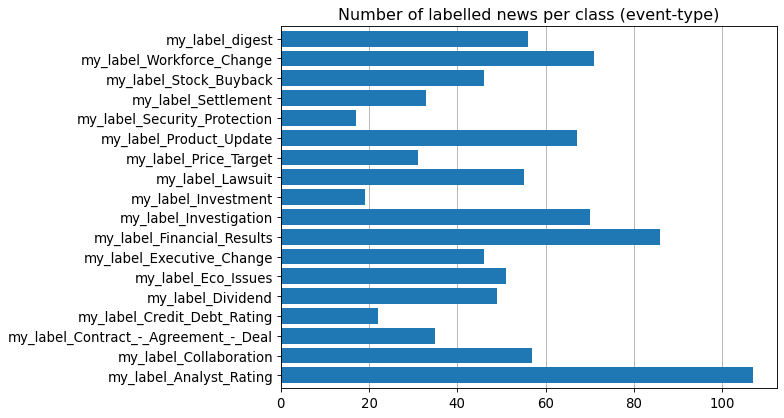

In [10]:
print(
    labelling_all_df[cols_of_labelling + ['my_label_digest']].sum().sum()
)
(labelling_all_df[cols_of_labelling + ['my_label_digest']].sum()).plot(kind='barh', width=0.8, figsize=(8,6))
plt.title('Number of labelled news per class (event-type)')
plt.grid(True, axis='x')
plt.savefig(path_project_folder + 'exhibits_saved/' + 'Number of labelled news per class (event-type).png', bbox_inches = "tight")

In [53]:
labelling_all_df['list_label'] = labelling_all_df[cols_of_labelling + ['my_label_digest']].values.tolist()
labelling_all_df.tail(1)

,storyId,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,my_label_Eco_Issues,my_label_Executive_Change,my_label_Financial_Results,my_label_Investigation,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest,list_label
850,urn:newsml:reuters.com:20191209:nNRAaepw3s:1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [54]:
labelling_all_df.sum()

storyId                                 urn:newsml:reuters.com:20201022:nNDL3RTZ1L:1ur...
my_label_Analyst_Rating                                                               107
my_label_Collaboration                                                                 57
my_label_Contract_-_Agreement_-_Deal                                                   35
my_label_Credit_Debt_Rating                                                            22
my_label_Dividend                                                                      49
my_label_Eco_Issues                                                                    51
my_label_Executive_Change                                                              46
my_label_Financial_Results                                                             86
my_label_Investigation                                                                 70
my_label_Investment                                                                    19
my_label_L

In [41]:
file_path = path_project_folder + 'labelling_all_df' + '.csv'
labelling_all_df.to_csv(file_path, index=False)

In [13]:
labelling_all_df.columns

Index(['storyId', 'my_label_Analyst_Rating', 'my_label_Asset_Sale',
       'my_label_Collaboration', 'my_label_Contract_-_Agreement_-_Deal',
       'my_label_Credit_Debt_Rating', 'my_label_Dividend',
       'my_label_Eco_Issues', 'my_label_Executive_Change',
       'my_label_Financial_Results', 'my_label_Investigation',
       'my_label_Investment', 'my_label_Lawsuit',
       'my_label_Merger_and_Acquisition', 'my_label_Price_Target',
       'my_label_Product_Update', 'my_label_Security_Protection',
       'my_label_Settlement', 'my_label_Stock_Buyback',
       'my_label_Workforce_Change', 'my_label_digest', 'list_label'],
      dtype='object')

# Разделим на train, validation и test выборки

In [12]:
# Може подгрузить csv, если хотим откатиться и не пересчитывать
key_words_detection_df = pd.read_csv(path_project_folder + "key_words_detection_df.csv")
print(key_words_detection_df.shape)

(257644, 109)


In [55]:
# Добавим тексты к нашему датасету с разметкой
lower_labelled_texts_list_types = pd.merge(
    key_words_detection_df, 
    labelling_all_df[['storyId', 'list_label']], 
    how="right", 
    on='storyId'
).drop_duplicates(
    subset=['storyId'], 
    keep='first'
).reset_index(drop=True) # [['story_wo_html', 'list_label']]

lower_labelled_texts_list_types['story_wo_html_lower'] = lower_labelled_texts_list_types['story_wo_html'].str.lower()
lower_labelled_texts_list_types = lower_labelled_texts_list_types.drop(columns=['story_wo_html'])

lower_labelled_texts_list_types = lower_labelled_texts_list_types[['story_wo_html_lower', 'list_label']]

In [56]:
lower_labelled_texts_one_type = pd.merge(
    key_words_detection_df, 
    labelling_all_df[['storyId', 'my_label_Executive_Change']], 
    how="right", 
    on='storyId'
).drop_duplicates(
    subset=['storyId'], 
    keep='first'
).reset_index(drop=True)[['story_wo_html', 'my_label_Executive_Change']]

lower_labelled_texts_one_type['story_wo_html_lower'] = lower_labelled_texts_one_type['story_wo_html'].str.lower()
lower_labelled_texts_one_type = lower_labelled_texts_one_type.drop(columns=['story_wo_html'])

lower_labelled_texts_one_type = lower_labelled_texts_one_type[['story_wo_html_lower', 'my_label_Executive_Change']]

In [57]:
print(
    'Number of labels:',
    len(lower_labelled_texts_list_types['list_label'][1])
)

Number of labels: 18


In [64]:
df = lower_labelled_texts_list_types['list_label'].apply(pd.Series)

df['story_wo_html_lower'] = lower_labelled_texts_list_types['story_wo_html_lower']
list(df.sum()[:len(cols_of_labelling) + 1])

[97.0,
 52.0,
 29.0,
 20.0,
 46.0,
 47.0,
 43.0,
 82.0,
 62.0,
 18.0,
 46.0,
 26.0,
 66.0,
 17.0,
 28.0,
 42.0,
 68.0,
 22.0]

In [65]:
lower_labelled_texts_list_types.to_csv(path_project_folder + 'lower_labelled_texts_list_types.csv')
lower_labelled_texts_one_type.to_csv(path_project_folder + 'lower_labelled_texts_one_type.csv')

# Рабочий BERT - запускал в Google Colab

https://colab.research.google.com/drive/1bsdQ9NTFMHNSczaJrwjFGNuUmDrBLVHY#scrollTo=DroMPlwnKALz

# Создадим датасет с текстами, которые мы хотим разметить BERT'ом

In [17]:
key_words_detection_df = pd.read_csv(path_project_folder + "key_words_detection_df.csv")
key_words_detection_df.head(2)

,ric,versionCreated,headline,storyId,sourceCode,story_wo_html,story_lang,Financial_Results_announces__s___Q1_Q2_Q3_Q4___result,Financial_Results__Q1_Q2_Q3_Q4___s__operating_profit,Financial_Results__Q1_Q2_Q3_Q4___s__sales,...,Eco_Issues_energy_management,Eco_Issues_sustainable,Eco_Issues_energy_efficient,Security_Protection_security_architecture,Security_Protection_security_requirement,Security_Protection_smartphone_security,Security_Protection_authentication,Security_Protection_hardware_attack,Security_Protection_verify_their_identity,Security_Protection_seamless_security
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,Igen Networks Corp. has joined the T-Mobile pa...,en,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,http://filings.ica.int.thomsonreuters.com/fili...,en,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
key_words_detection_df_sample = key_words_detection_df
key_words_detection_df_sample['story_wo_html_lower'] = key_words_detection_df_sample['story_wo_html'].str.lower()
key_words_detection_df_sample = key_words_detection_df_sample[['storyId', 'story_wo_html_lower']]

In [19]:
key_words_detection_df_sample = key_words_detection_df_sample

In [20]:
key_words_detection_df_sample.to_csv(path_project_folder + 'key_words_detection_df_sample.csv', index=False)

# Далее идут неудавшиеся попытки

## Попытка 1 после Москвы построить нейронку

https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d

The model is also pre-trained on two unsupervised tasks, masked language modeling and next sentence prediction.

Bert input leght limitation

We will convert the InputExample to the feature that is understood by BERT. The feature will be represented by class InputFeatures.
- input_ids: list of numerical ids for the tokenised text
- input_mask: will be set to 1 for real tokens and 0 for the padding tokens
- segment_ids: for our case, this will be set to the list of ones
- label_ids: one-hot encoded labels for the text

PreTrainedBertModel - не знает, что это за сущность

## Попытка 2 после Москвы

https://www.kaggle.com/notebooks?sortBy=voteCount&searchQuery=bert

Попробовал код ниже - не подгружается библиотека fastai.callbacks

Рекомендуют сделать среду с помощью конды

## Попытка 3 после Москвы

https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=cfNIhN19te3N

Мне кажется, не сработало на моих данных, потому что там размечают предложения и вставляют PAD SEP CLS куда надо, если бы текст был бы просто предложением

## Попытка 4 после Москвы

https://www.youtube.com/watch?v=wG2J_MJEjSQ


## Попытка 5 после Москвы

In [11]:
train_path = path_project_folder + 'toxic_comments/train.csv'
test_path = path_project_folder + 'toxic_comments/test.csv'
test_labels_path = path_project_folder + 'toxic_comments/test_labels.csv'
subm_path = path_project_folder + 'toxic_comments/sample_submission.csv'